<img style="float: left;" src="attachment:D2Klogo.png" width="20%"> 

<center>

# Welcome to COMP 680 #
### Statistics for Computing and Data Science ###

### Homework 6 ###

In [154]:
### standard imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline  
plt.style.use('fivethirtyeight')
plt.rcParams["patch.force_edgecolor"] = True
import seaborn as sns

import statsmodels.api as sm
from statsmodels.sandbox.predict_functional import predict_functional
import scipy.stats as st
import math

import warnings
warnings.filterwarnings("ignore")

## NHANES Case Study

In this homework, we will be working with the [NHANES](https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2015) data again. We will perform the same processing and cleaning of the data as before:

In [155]:
nhanes = pd.read_csv("nhanes_2015_2016.csv")
# fix column names to be informative
new_col_names = {'SEQN':'ID',
                 'ALQ130':'Avg_drinks_per_day', 'SMQ020': 'Smoker', 
                 'RIAGENDR':'Gender', 'RIDAGEYR':'Age', 'RIDRETH1':'Race', 
                 'DMDCITZN':'Citizenship', 'DMDEDUC2':'Education_Level', 
                 'DMDMARTL':'Marital_Status', 'INDFMPIR':'Family_PIR', 
                 'BPXSY1':'Systolic_Blood_Pressure', 'BPXDI1':'Diastolic_Blood_Pressure', 
                 'BMXWT':'Weight', 'BMXHT':'Height', 'BMXBMI':'BMI', 
                 'BMXLEG':'Leg_Length', 'BMXARML':'Arm_Length', 
                 'BMXARMC': 'Arm_Circumference', 'BMXWAIST':'Waist_Circumference'}
nhanes.rename(columns=new_col_names, inplace=True)
# replace some code as missing values
nhanes['ALQ101'] =  nhanes['ALQ101'].replace({7:np.NaN, 9:np.NaN})
nhanes['ALQ110'] =  nhanes['ALQ110'].replace({7:np.NaN, 9:np.NaN})
nhanes['Avg_drinks_per_day'] =  nhanes['Avg_drinks_per_day'].replace({777:np.NaN, 999:np.NaN})
nhanes['Smoker'] = nhanes['Smoker'].replace({7:np.NaN, 9:np.NaN})
nhanes['Education_Level'] = nhanes['Education_Level'].replace({7:np.NaN, 9:np.NaN})
nhanes['Marital_Status'] = nhanes['Marital_Status'].replace({77:np.NaN})
nhanes['Citizenship'] = nhanes['Citizenship'].replace({7:np.NaN, 9:np.NaN})
# there are quite a few missing values but most model will exclude them
nhanes.head()

,ID,ALQ101,ALQ110,Avg_drinks_per_day,Smoker,Gender,Age,Race,Citizenship,Education_Level,...,BPXSY2,BPXDI2,Weight,Height,BMI,Leg_Length,Arm_Length,Arm_Circumference,Waist_Circumference,HIQ210
0,83732,1.0,NaN,1.0,1.0,1,62,3,1.0,5.0,...,124.0,64.0,94.8,184.5,27.8,43.3,43.6,35.9,101.1,2.0
1,83733,1.0,NaN,6.0,1.0,1,53,3,2.0,3.0,...,140.0,88.0,90.4,171.4,30.8,38.0,40.0,33.2,107.9,NaN
2,83734,1.0,NaN,NaN,1.0,1,78,3,1.0,3.0,...,132.0,44.0,83.4,170.1,28.8,35.6,37.0,31.0,116.5,2.0
3,83735,2.0,1.0,1.0,2.0,2,56,3,1.0,5.0,...,134.0,68.0,109.8,160.9,42.4,38.5,37.7,38.3,110.1,2.0
4,83736,2.0,1.0,1.0,2.0,2,42,4,1.0,4.0,...,114.0,54.0,55.2,164.9,20.3,37.4,36.0,27.2,80.4,2.0


In [156]:
nhanes[['Smoker']]

,Smoker
0,1.0
1,1.0
2,1.0
3,2.0
4,2.0
...,...
5730,1.0
5731,2.0
5732,1.0
5733,1.0


**Question 1:** 
We generate a binary variable reflecting whether a person has smoked at least 100 cigarettes in life, based on the original [SMQ020](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/SMQ_I.htm#SMQ020) variable in NHANES, renamed above to be `Smoker`.

In [157]:
sum(nhanes['Smoker']==0)

0

In [158]:
# recode Smoker so 1 is smoker and 0 is non-smoker
nhanes['Smoker'] = nhanes['Smoker'].replace({2:0})
nhanes.head()

,ID,ALQ101,ALQ110,Avg_drinks_per_day,Smoker,Gender,Age,Race,Citizenship,Education_Level,...,BPXSY2,BPXDI2,Weight,Height,BMI,Leg_Length,Arm_Length,Arm_Circumference,Waist_Circumference,HIQ210
0,83732,1.0,NaN,1.0,1.0,1,62,3,1.0,5.0,...,124.0,64.0,94.8,184.5,27.8,43.3,43.6,35.9,101.1,2.0
1,83733,1.0,NaN,6.0,1.0,1,53,3,2.0,3.0,...,140.0,88.0,90.4,171.4,30.8,38.0,40.0,33.2,107.9,NaN
2,83734,1.0,NaN,NaN,1.0,1,78,3,1.0,3.0,...,132.0,44.0,83.4,170.1,28.8,35.6,37.0,31.0,116.5,2.0
3,83735,2.0,1.0,1.0,0.0,2,56,3,1.0,5.0,...,134.0,68.0,109.8,160.9,42.4,38.5,37.7,38.3,110.1,2.0
4,83736,2.0,1.0,1.0,0.0,2,42,4,1.0,4.0,...,114.0,54.0,55.2,164.9,20.3,37.4,36.0,27.2,80.4,2.0


 **1.1:** Fit a logistic regression model [sm.GLM.from_formula](https://www.statsmodels.org/dev/examples/notebooks/generated/glm_formula.html) using only one covariate Gender to predict smoking status. Reminder the variable `Gender` is coded as following, but you should include in the model correctly as a categorical variable, and use the Male category as reference!
 - Gender:
    - 1: Male
    - 2: Female

In [159]:
formula = "Smoker ~ C(Gender)"
mod1 = sm.GLM.from_formula(formula=formula, data=nhanes, family=sm.families.Binomial()).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Smoker   No. Observations:                 5725
Model:                            GLM   Df Residuals:                     5723
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3734.8
Date:                Mon, 05 Dec 2022   Deviance:                       7469.6
Time:                        18:21:00   Pearson chi2:                 5.72e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04428
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0530      0.038      1.391      0.164      -0.022       0.128
C(Gender)[T.2]    -0.8774      0.055    -15.908      0.000      -0.985      -0.769
==================================================================================
"""

In [160]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


**1.2:** Calculate the probability, odds, and log odds of the variable `Smoker` for females and for males, **without using the model in 1.1** What is the log odds of smoking for males?  Then calculate the log odds ratio for females relative to males, that is the log odds ratio of females minus the log odds ratio of males.

**Hint:** You may find [`df.pivot_table`](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html) useful.

In [161]:
# enter your code here
pd.pivot_table(nhanes, values='Smoker', index=['Gender'], aggfunc=['sum', 'count'])

,sum,count
,Smoker,Smoker
Gender,,
1,1413.0,2753
2,906.0,2972


In [162]:
906-2972

-2066

In [163]:
# Log odds ratio for males:
lodds_male = math.log(1413/(2753-1413))
# Log odds ratio for females:
lodds_female = math.log(906/(2972-906))
# Log odds ratio for females relative to males:
lodds_female_to_male = lodds_female - lodds_male

In [164]:
# print out result
print('Smoking log odds ratio for male: %.4f' % lodds_male)
print('Smoking log odds ratio for female: %.4f' % lodds_female)
print('Smoking log odds ratio for female relative to male: %.4f' % lodds_female_to_male)

Smoking log odds ratio for male: 0.0530
Smoking log odds ratio for female: -0.8243
Smoking log odds ratio for female relative to male: -0.8774


**1.3:** If your calculation in **1.2** is correct, you should end up with almost identical numbers as the coefficients in model in **1.1** (assuming you fit the model correctly). What are the interpretations for the intercept and slope for the model in **1.1**? I hope the above exercise helps with the interpretations!

**Solution:**  

**Interpretation for intercept:** The intercept represents the log odds ratio of being a smoker if you are a man.

**Interpretation for slope:** The slope represents the change in the log odds ratio of being a smoker if you are a woman in comparison to a man. As it is negative, we can interpret it as women are less likely to be smokers in comparison to men.


**1.4:** Based on the model results in **1.1**, can we conclude that more than 50% of male are smokers in general population?

**Solution:**: 

As the interception is positive, we can tell that the probability of being a smoker is greater than not being a smoker when being a man (by the definition of log odds ratio, we can recall that the log odds ratio represents the log of the probability of being a smoker over the probability of not being a smoker). 

The fact that we yield a positive value, means that the numeratior is greater than the denominator. Therefore, we can conclude that the probality of being a smoker if you are a man is greater than 50%. 

**1.5:** Does there appear to be a significant difference between the smoking status of female and male? If so, can you quantify the difference based on the model in **1.1**: how much more likely that male are smokers than female?

In [165]:
# calculate odds ratio of male over female
# notice the model coefficient is female over male, so need to do 1 / 
odd_m_f = 1/math.exp(-0.8774)
print(odd_m_f)

2.404639508963792


**Solution:**: 

We can see that the p_value is quite small (<0.05), therefore we can say there is significant difference between smoking status of female vs men. Men are **2.405** more likely to be smokers than women.

**Question 2:** We will build upon the model in **Question 1** by adding more covariates from the data.

**2.1:** Let's first add age to the model, so fit a logistic regression model using Gender and Age to predict smoking status.

In [166]:
# enter your code here
formula = "Smoker ~ C(Gender) + Age"
mod1 = sm.GLM.from_formula(formula=formula, data=nhanes, family=sm.families.Binomial()).fit()
print(mod1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Smoker   No. Observations:                 5725
Model:                            GLM   Df Residuals:                     5722
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3637.6
Date:                Mon, 05 Dec 2022   Deviance:                       7275.2
Time:                        18:21:01   Pearson chi2:                 5.73e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.07618
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.9656      0.084    -11.

**2.2:** Based on the model result in **2.1**, how do we interpret all the coefficients?

**Solution:**  

Interpretation for intercept: The intercept loses some interpretation. Theorically, in this case, the intercept represents the log odds ratio of being a smoker for an average men with age 0. 

Interpretation for slope of female: If you don't change the age of the person, the log odds ratio of being smoker if you are a women decreases by that slope in comparison to the men. Also, we can interpret that women are less likely to be smokers than men of same age, taking into account that the slope is negative.

Interpretation for slope of age: The age slope represents the change in the log odds ratio of being a smoker if we increase the age by one unit, and mantain the same gender. As it is positive, we can say that elder people are more likely to be smokers.

**2.3:** Let's now add an interaction term of age and gender to the model!

In [167]:
# enter your code here
formula = "Smoker ~ C(Gender) + Age + C(Gender)*Age"
mod1 = sm.GLM.from_formula(formula=formula, data=nhanes, family=sm.families.Binomial()).fit()
print(mod1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Smoker   No. Observations:                 5725
Model:                            GLM   Df Residuals:                     5721
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3629.2
Date:                Mon, 05 Dec 2022   Deviance:                       7258.5
Time:                        18:21:01   Pearson chi2:                 5.72e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.07888
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.2604      0

**2.4:** Based on the model result in **2.3**, how do we interpret all the coefficients? What does it imply if the interaction term is significant?

**Solution:**  

We can see that in this case the interaction term becomes significant, however the gender alone becomes insignificant. We can then infer that the effect of gender is different according to the age. Taking into account the slope of the age term is positive, we can say that older people have a higher tendency to be smokers.

Although, because the interaction term is negative the increase in odds ratio for men and women are not the same for a single unit increase in age, the increase in odds ratio is less for women.

The intercep as in the previous exercise represents the log odds ratio of being a smoker for a man with age 0.

**2.5:** Adding the following variables to model in **2.3**. Based on results, make some general conclusions about how each variable affects the probability of smoking. As a reminder, the coding for the following vriables are listed:
- Race: 
    - 1: Mexican American
    - 2: Other Hispanic
    - 3: Non-Hispanic White
    - 4: Non-Hispanic Black
    - 5: Other Race Including Multi-Racial
- Education_Level:
    - 1: < 9th grade
    - 2: 9-11th grade
    - 3: HS/GED
    - 4: Some college/AA
    - 5: College
- Marital_Status:
    - 1: Married
    - 2: Widowed
    - 3: Divorced
    - 4: Separated
    - 5: Never married
    - 6: Living w/partner
- BMI: numerical

In [168]:
# enter your code here
formula = "Smoker ~ C(Gender) + Age + C(Gender)*Age + C(Race) + C(Education_Level) + C(Marital_Status) + BMI"
mod1 = sm.GLM.from_formula(formula=formula, data=nhanes, family=sm.families.Binomial()).fit()
print(mod1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Smoker   No. Observations:                 5393
Model:                            GLM   Df Residuals:                     5375
Model Family:                Binomial   Df Model:                           17
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3288.0
Date:                Mon, 05 Dec 2022   Deviance:                       6576.0
Time:                        18:21:01   Pearson chi2:                 5.38e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1308
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

**Solution:**  

**Gender:** we can see that the p-value is large, so gender alone is not significant.

**Gender*Age:** we can still see that the p-value is small, and considering the slope is still negative, we can infer that women are less likely to be smokers than men.

**Race:** in the case of race, the model uses Mexican American as reference. In the case of T2, T4 and T5; the p-value is greater than 0.05, so we cannot say that the odds ratio of being a smoker when being a "Other Hispanic", "Non-Hispanic Black" and "Other Race - Including multiracial" is significantly different in comparison to Mexican Americans.

On the other hand, the p-value of T3 is still small therefore significant. As the slope is positive, we can say that Non-Hispanic White people are more likely to be smokers in comparison to Mexican Americans.

**Education Level:** In the case of education level, the p_value are quite small. The people with an education level of less than 9th grade are taken as reference. People with an education level of 9-11th grade, HS/GED and some college/AA are more likely to be smokers than the reference as the slope is positive.

On the other hand, we can observe that people with an education level of college have a negative slope which means they are less likely to be smokers than the reference.

**Marital Status:** In the case of marital status, married people are taken as reference. In all the cases, the p-value is small, therefore we can say that there is a difference in comparison with the reference. Moreover, considering the slope is positive, we can conclude that people that are "Widowed", "Divorced", "Separated", "Never married" and "Living w/partner" are more likely to be smokers than married people.

**Age:** In the case of age, the slope is still significant and positive; so we can still say that elder people are more likely to be smokers.

**BMI:** Fo the BMI, the p-value is large, so we cannot conclude that people with different BMI are more nor less likely to be smokers.

**Intercept:** The intercept loses interpretabilty; but, theoritically, it represents the log odds ratio of being a smoker, if you are mexican american male of age 0 with BMI of 0, married, with education level of less than 9th grade.


**Question 3:** We will create a categorical variable for drinking status based on [`ALQ101` and `ALQ110`](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/ALQ_I.htm#Codebook):
- drinking
    - 0: fewer than 12 alcohol drinks in lifetime (`ALQ110`=2).
    - 1: more than 12 alcohol drinks in lifetime but not in a year (`ALQ110`=1).
    - 2: more than 12 alcohol drinks in a year (`ALQ101`=1).

In [169]:
nhanes['Drinking'] = nhanes['ALQ110']
nhanes.loc[nhanes['ALQ110']==2, 'Drinking'] = 0
nhanes.loc[nhanes['ALQ101']==1, 'Drinking'] = 2
# check for counts
nhanes['Drinking'].value_counts()

2.0    3477
0.0     979
1.0     747
Name: Drinking, dtype: int64

**3.1:** Fit a multinomial regression model [sm.MNLogit](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.MNLogit.html#statsmodels.discrete.discrete_model.MNLogit) using the following covariates:
- Gender:
    - 1: Male
    - 2: Female
- Age: numerical
- BMI: numerical

**Note:** MNLogit function does not support formula and cannot handle NaNs, so you need to do dummy variable coding and drop all rows with NaNs. 

In [170]:
clean_nhanes = nhanes.dropna(subset=['Drinking','Age','Gender','BMI'])
clean_nhanes.reset_index(inplace=True)
clean_nhanes['Female'] = clean_nhanes['Gender'].map({1: 0, 2: 1})

In [171]:
# enter your code here
# notice MNLogit does not support formula and cannot handle NaN
# need to create a dummy variable for Female and drop records with NaN
clean_nhanes.endog = clean_nhanes['Drinking']
clean_nhanes.exog = sm.add_constant(clean_nhanes[['Female', 'Age' ,'BMI']])
model4 = sm.MNLogit(clean_nhanes.endog, clean_nhanes.exog)
result = model4.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.822527
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:               Drinking   No. Observations:                 5146
Model:                        MNLogit   Df Residuals:                     5138
Method:                           MLE   Df Model:                            6
Date:                Mon, 05 Dec 2022   Pseudo R-squ.:                 0.04472
Time:                        18:21:02   Log-Likelihood:                -4232.7
converged:                       True   LL-Null:                       -4430.9
Covariance Type:            nonrobust   LLR p-value:                 1.751e-82
==============================================================================
Drinking=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5713      0.248     -6.334      0.000      -2.057      -1.085
Female         0.0203      0.107      0.189      0.850      -0.189       0.230
Age            0.0108      0.003      4.066      0.000       0.006       0.016
BMI            0.0251      0.007      3.755      0.000       0.012       0.038
------------------------------------------------------------------------------
Drinking=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6296      0.184      8.840      0.000       1.268       1.991
Female        -1.1401      0.078    -14.609      0.000      -1.293      -0.987
Age           -0.0010      0.002     -0.489      0.625      -0.005       0.003
BMI            0.0112      0.005      2.110      0.035       0.001       0.022
==============================================================================
"""

**3.2:** How do we interpret the slopes for `Female`?

**Solution:**  

While comparing drinking less and more than 12 drinks in their lifetime, we can see that the p-value is quite large (greater than alpha), therefore we should not make any inference on that as it is not significant.

However, while comparing with more than 12 drinks in a year, we see p_value is quite small, so we can say that women are less likely to drink more than 12 dirnks in a year than men as the slope is negative.

**3.3:** How do we interpret the slopes for `Age`?

**Solution:**  
In the case of age, it is only significant in the first comparison, so we can say that older people tend to have drunk more than 12 drinks over their lifetime than younger people. This actually makes sense, as the period is larger, therefore the odds of drinking more also increases. 

For the second part, we cannot make an inference, because the p-value is greater than alpha.

**3.4:** How do we interpret the slopes for `BMI`?

**Solution:**  

As BMI have a positive slope in both cases, we can say that people with larger BMI tend to drink more than people with less BMI. People with higher BMI are more likely to have drunk more than 12 drinks in their lifetime and in a year.

**3.5:** Let's add `Marital_Status` in the model, but instead of all the categories in the data, create a dummy variable to indicate whether this person is married (`Marital_Status=1`) or not, and use that as your covariate. Is there statistical evidence that the drinking status differs between married and unmarried folks when we control gender, age and BMI?

In [172]:
# enter your code here
# notice MNLogit does not support formula and cannot handle NaN
# need to create a dummy variable for Married and drop NaN
clean_nhanes['Married'] = (clean_nhanes['Marital_Status']==1)*1
clean_nhanes = clean_nhanes.dropna(subset=['Drinking','Age','Gender','BMI','Married'])

In [173]:
clean_nhanes.endog = clean_nhanes['Drinking']
clean_nhanes.exog = sm.add_constant(clean_nhanes[['Female', 'Age' ,'BMI','Married']])
model4 = sm.MNLogit(clean_nhanes.endog, clean_nhanes.exog)
result = model4.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.822462
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:               Drinking   No. Observations:                 5146
Model:                        MNLogit   Df Residuals:                     5136
Method:                           MLE   Df Model:                            8
Date:                Mon, 05 Dec 2022   Pseudo R-squ.:                 0.04479
Time:                        18:21:02   Log-Likelihood:                -4232.4
converged:                       True   LL-Null:                       -4430.9
Covariance Type:            nonrobust   LLR p-value:                 8.376e-81
==============================================================================
Drinking=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5522      0.251     -6.191      0.000      -2.044      -1.061
Female         0.0139      0.108      0.130      0.897      -0.197       0.225
Age            0.0111      0.003      4.119      0.000       0.006       0.016
BMI            0.0252      0.007      3.763      0.000       0.012       0.038
Married       -0.0610      0.100     -0.611      0.541      -0.257       0.135
------------------------------------------------------------------------------
Drinking=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6457      0.186      8.860      0.000       1.282       2.010
Female        -1.1461      0.078    -14.614      0.000      -1.300      -0.992
Age           -0.0007      0.002     -0.343      0.732      -0.005       0.003
BMI            0.0113      0.005      2.125      0.034       0.001       0.022
Married       -0.0604      0.076     -0.792      0.428      -0.210       0.089
==============================================================================
"""

**Solution:**  

We can only take into account the second comparison, as the p_value for the first one is too small. In the second, as the slope is negative, we can say that married people are less likely to drink more than 12 drinks per year than unmarried people.

**Question 4:** Now let's look at the variable `Avg_drinks_per_day` and use [sm.Poisson](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Poisson.html#statsmodels.discrete.discrete_model.Poisson) to regress average number of drinks per day on other variables.

**4.1:** Create a barchart to visualize the distribution of average number of drinks in the data and calculate the mean and variance. 

**Note:** The column `Avg_drinks_per_day` contains missing values, let's create a new column `Drinks` and fill in all missing values. According to the [codebook](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/ALQ_I.htm#Codebook), let's fill in 0 for the missing values as an approximation. 

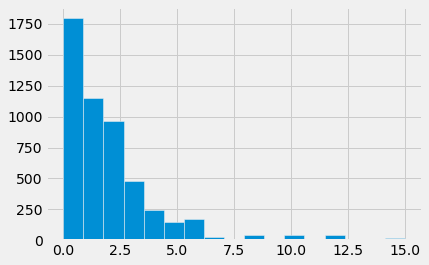

In [174]:
# enter your code here
clean_nhanes['Drinks'] =  clean_nhanes['Avg_drinks_per_day'].replace({np.NaN:0})
plt.hist(clean_nhanes['Drinks'], bins=int(max(clean_nhanes['Drinks']))+2, align='mid')
plt.show()

In [175]:
# print out result
mean = np.mean(clean_nhanes['Drinks'])
var = np.var(clean_nhanes['Drinks'])
print('Mean of average number of drinks per day %.3f' % mean)
print('Variance of average number of drinks per day %.3f' % var)

Mean of average number of drinks per day 1.782
Variance of average number of drinks per day 5.259


**4.2:** Fit a Poisson regression model using the same covariates as the model in **3.5** and `Drinks` as the outcome. 

In [176]:
# enter your code here
# take out the columns and drop NaN
clean_nhanes = clean_nhanes.dropna(subset=['Drinks','Age','BMI','Married'])
clean_nhanes.endog = clean_nhanes['Drinks']
clean_nhanes.exog = sm.add_constant(clean_nhanes[['Female', 'Age' ,'BMI','Married']])
model6 = sm.Poisson(clean_nhanes.endog, clean_nhanes.exog)
result6 = model6.fit(method="newton")
result6.summary()

Optimization terminated successfully.
         Current function value: 1.969151
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                 Drinks   No. Observations:                 5146
Model:                        Poisson   Df Residuals:                     5141
Method:                           MLE   Df Model:                            4
Date:                Mon, 05 Dec 2022   Pseudo R-squ.:                 0.07433
Time:                        18:21:02   Log-Likelihood:                -10133.
converged:                       True   LL-Null:                       -10947.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3019      0.049     26.675      0.000       1.206       1.398
Female        -0.6230      0.022    -28.471      0.000      -0.666      -0.580
Age           -0.0157      0.001    -25.871      0.000      -0.017      -0.015
BMI            0.0099      0.001      6.859      0.000       0.007       0.013
Married       -0.0519      0.022     -2.358      0.018      -0.095      -0.009
==============================================================================
"""

**4.3:** How do we interpret the slope for `Age`?

**Solution:**  

The slope of age can be interpreted as follows. If we increase the age by one unit by maintaining everything else the same, the number of drinks per day decreases by exponential of the slope. In other words, elder people tend to drink less per day than younger people.

**4.4:** Compare a married female with unmarried male with same age and BMI, does the model result suggest which one has a higher expected value of average number of drinks per day?

**Solution:**  

By looking at the slopes, we can see that married and female have negative slopes, therefore by having those attributes we can expect married female to have a smaller expected value of average drinks per day than unmarried males.

**4.5:** For a married female of age 36 with BMI 25, what is the expected number of drinks per day according to your model? You can also use this model to predict **your** expected number of drinks per day, mine is 1.187(>_<)!

In [177]:
# enter your code here
q1 = math.exp(1.5095 - 0.6447*1 - 0.0186*36 + 0.0094*25 - 0.0993*1)
q2 = math.exp(1.5095 - 0.6447*0 - 0.0186*24 + 0.0094*19 - 0.0993*0)

print("The expected number of drinks of a married female of age 36 with BMI 25 is", round(q1,3))
print("My expected number of drinks is", round(q2,3))

The expected number of drinks of a married female of age 36 with BMI 25 is 1.392
My expected number of drinks is 3.461


You're done with HW 6, the last homework!!! WoW~ 

* **Save and Checkpoint** from the File menu,
* **Close and Halt** from the File menu,
* **Rename your ipynb file**, replacing LASTNAME with your last name,
* **Upload** your file to the course website.